In [1]:
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors

import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

In [2]:
train = [ mol for mol in Chem.SDMolSupplier('./datasets/solubility.train.sdf')]
test = [ mol for mol in Chem.SDMolSupplier('./datasets/solubility.test.sdf')]

In [3]:
descs = [desc_name[0] for desc_name in Descriptors._descList]
desc_calc = MoleculeDescriptors.MolecularDescriptorCalculator(descs)

In [4]:
X = [desc_calc.CalcDescriptors(mol) for mol in train]
y = [mol.GetPropsAsDict()["SOL"] for mol in train]
test_X = [desc_calc.CalcDescriptors(mol) for mol in test]
test_y = [mol.GetPropsAsDict()["SOL"] for mol in test]

In [5]:
from sklearn.model_selection import train_test_split
(train_x, valid_x,
 train_y, valid_y) = train_test_split(
    X, y, test_size=0.2, random_state=0,
)

In [6]:
param = {'num_leaves': 31,
     'min_data_in_leaf': 30, 
     'objective':'regression',
     'max_depth': -1,
     'learning_rate': 0.01,
     "min_child_samples": 20,
     "boosting": "gbdt",
     "feature_fraction": 0.9,
     "bagging_freq": 1,
     "bagging_fraction": 0.9 ,
     "bagging_seed": 11,
     "metric": 'rmse',
     "lambda_l1": 0.1,
     "verbosity": -1,
     "nthread": 4,
     "random_state": 0}

In [7]:
lgb_train = lgb.Dataset(train_x,
                        label=train_y,
                        free_raw_data=False)
lgb_test = lgb.Dataset(valid_x,
                       label=valid_y,
                       free_raw_data=False)

In [8]:
reg = lgb.train(
                param,
                lgb_train,
                valid_sets=[lgb_train, lgb_test],
                valid_names=['train', 'test'],
                num_boost_round=10000,
                early_stopping_rounds= 300,
                verbose_eval=100
                )

Training until validation scores don't improve for 300 rounds.
[100]	train's rmse: 0.954632	test's rmse: 1.02135
[200]	train's rmse: 0.592873	test's rmse: 0.729525
[300]	train's rmse: 0.456173	test's rmse: 0.643088
[400]	train's rmse: 0.387969	test's rmse: 0.616696
[500]	train's rmse: 0.344624	test's rmse: 0.60439
[600]	train's rmse: 0.312954	test's rmse: 0.599289
[700]	train's rmse: 0.286946	test's rmse: 0.595187
[800]	train's rmse: 0.264333	test's rmse: 0.593469
[900]	train's rmse: 0.244957	test's rmse: 0.593028
[1000]	train's rmse: 0.228082	test's rmse: 0.591473
[1100]	train's rmse: 0.213238	test's rmse: 0.591483
[1200]	train's rmse: 0.199845	test's rmse: 0.590999
[1300]	train's rmse: 0.187987	test's rmse: 0.590624
[1400]	train's rmse: 0.177225	test's rmse: 0.590462
[1500]	train's rmse: 0.167461	test's rmse: 0.590748
[1600]	train's rmse: 0.158487	test's rmse: 0.591348
[1700]	train's rmse: 0.150172	test's rmse: 0.59091
Early stopping, best iteration is:
[1404]	train's rmse: 0.176853	

In [9]:
output = reg.predict(train_x, num_iteration=reg.best_iteration)
print("train_RMSE: {:.4f}".format(mean_squared_error(output,train_y)**0.5))
output = reg.predict(test_X, num_iteration=reg.best_iteration)
print("test_RMSE : {:.4f}".format(mean_squared_error(output,test_y)**0.5))

train_RMSE: 0.1769
test_RMSE : 0.5891


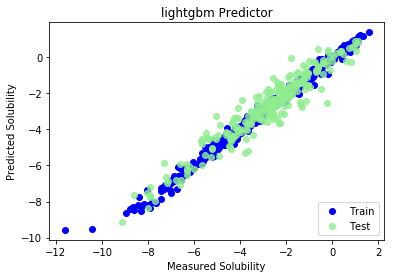

In [11]:
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(train_y, reg.predict(train_x, num_iteration=reg.best_iteration), label = 'Train', c = 'blue')
plt.title('lightgbm Predictor')
plt.xlabel('Measured Solubility')
plt.ylabel('Predicted Solubility')
plt.scatter(test_y, reg.predict(test_X, num_iteration=reg.best_iteration), c = 'lightgreen', label = 'Test', alpha = 0.8)
plt.legend(loc = 4)
plt.show()